In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
proj_root = Path.cwd().resolve().parent
sys.path.insert(0, str(proj_root))

Paths

In [3]:
RAW_DATA = proj_root / "data" / "raw"
PROCESSED_DATA = proj_root / "data" / "processed"

In [4]:
train_path = RAW_DATA / "train.csv"

Load data

In [5]:
df = pd.read_csv(train_path)

In [6]:
print("train shape:", df.shape)

train shape: (1460, 81)


Check for missing values

In [7]:
missing = df.isnull().sum()
missing = missing[missing>0].sort_values(ascending = False)
missing_percent = (missing / len(df)) * 100
missing_summary = pd.DataFrame({"Missing values":missing, "Percent": missing_percent})
missing_summary

,Missing values,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


**Pre-Pipeline Manual Cleaning:**

Drop columns with >50% missing values

In [8]:
df.drop(columns = ["PoolQC","MiscFeature","Alley", "Fence", "MasVnrType"], inplace = True)


In [9]:
missing = df.isnull().sum()
missing_cols = missing[missing>0].sort_values(ascending = False).index.tolist()
missing_cols

['FireplaceQu',
 'LotFrontage',
 'GarageYrBlt',
 'GarageFinish',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtCond',
 'BsmtQual',
 'BsmtFinType1',
 'MasVnrArea',
 'Electrical']

In [10]:
for col in missing_cols:
    df[col] = df[col].fillna("None")
cat_cols = df.select_dtypes(include = ["O"]).columns
df[cat_cols] = df[cat_cols].astype(str)

Which columns are missing in test

**Outlier removal & basic feature engineering**

Text(0, 0.5, 'SalePrice')

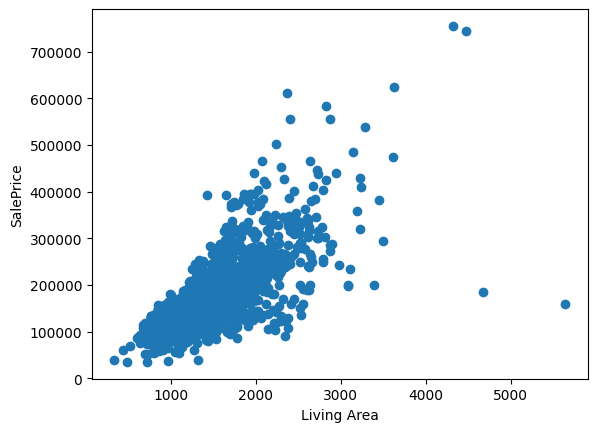

In [11]:
plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.xlabel("Living Area")
plt.ylabel("SalePrice")

In [12]:
outliers = (df["GrLivArea"] > 4000) & (df["SalePrice"] < 300000)
df = df[~outliers]

**Define Features and Target**

In [13]:
X = df.drop(columns = ["SalePrice"])
y = df["SalePrice"]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

cat_features = X_train.select_dtypes(include = ["O"]).columns
num_features = X_train.select_dtypes(include = ["int64", "float64"]).columns

**Now we will build a pipeline:**

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])


cat_transformer = Pipeline(steps= [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers = [
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

**Full Pipeline: Preprocess + model**

Model 1:

In [16]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

lightgbm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model),
])

lightgbm_pipeline.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 203
[LightGBM] [Info] Start training from score 180823.598628


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Model Evaluation**

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = lightgbm_pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

mape = (abs((y_test - y_pred) / y_test)).mean() * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE %:", mape)


MAE: 16449.467970279762
RMSE: 23760.131853789793
R2: 0.8977965730242401
MAPE %: 10.012440617257626


C:\Users\Mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Model 2:

In [18]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=500, 
    learning_rate=0.05, 
    random_state=42, 
    verbose=0
)


cboost_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model),
])

cboost_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = cboost_pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

mape = (abs((y_test - y_pred) / y_test)).mean() * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE %:", mape)

MAE: 14924.5283591554
RMSE: 20492.9500427584
R2: 0.9239714464155381
MAPE %: 9.089931890547783


In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    cboost_pipeline,
    X,
    y,
    cv=5,
    scoring="r2"
)

print("CV R2:", cv_scores.mean(), "+/-", cv_scores.std())


CV R2: 0.9128178411620741 +/- 0.0080921180398352


For production in this project, we will pick the CatBoost pipeline:

**For production, we need to pick top 15 features and retrain the model on these important features**

Get Feature Importances from CatBoost:

In [21]:
# get fitted preprocessor
pre = cboost_pipeline.named_steps["preprocessor"]

# get numeric feature names
num_feats = pre.named_transformers_["num"].get_feature_names_out()

# get categorical OHE names
cat_feats = pre.named_transformers_["cat"]\
               .named_steps["ohe"]\
               .get_feature_names_out()

# combine
all_features = list(num_feats) + list(cat_feats)


In [22]:
import pandas as pd

model = cboost_pipeline.named_steps["model"]

importance = pd.DataFrame({
    "feature": all_features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)


In [23]:
# extract original column name
importance["orig_feature"] = importance["feature"]\
    .str.split("_")\
    .str[0]


In [24]:
agg_importance = (
    importance
    .groupby("orig_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)
print(agg_importance.head(30))

orig_feature
OverallQual     26.253187
GrLivArea       12.530792
1stFlrSF         5.401643
TotalBsmtSF      4.932179
BsmtFinSF1       4.734338
LotArea          4.454816
x30              3.805771
GarageCars       3.350968
x21              3.248519
TotRmsAbvGrd     2.670646
2ndFlrSF         2.392602
YearBuilt        1.988933
x32              1.724445
GarageArea       1.675132
FullBath         1.395955
OverallCond      1.037064
x18              1.022528
x23              1.004686
YearRemodAdd     0.980898
MSSubClass       0.975411
x3               0.971014
x33              0.950138
OpenPorchSF      0.919941
x8               0.899182
x35              0.820433
HalfBath         0.786690
x27              0.676511
x40              0.650429
WoodDeckSF       0.494952
x37              0.475832
Name: importance, dtype: float64


Pick important features:

In [25]:
top_features = [
    "OverallQual",
    "GrLivArea",
    "1stFlrSF",
    "TotalBsmtSF",
    "BsmtFinSF1",
    "LotArea",
    "GarageCars",
    "TotRmsAbvGrd",
    "2ndFlrSF",
    "YearBuilt",
    "GarageArea",
    "FullBath",
    "OverallCond",
    "YearRemodAdd",
    "MSSubClass"
]


Final Pipeline:

In [26]:
# Reduced columns
X_train_red = X_train[top_features]
X_test_red  = X_test[top_features]

In [27]:
final_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        random_state=42,
        verbose=0
    )),
])


In [28]:
final_pipeline.fit(X_train_red, y_train)


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = final_pipeline.predict(X_test_red)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

mape = (abs((y_test - y_pred) / y_test)).mean() * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE %:", mape)

MAE: 15902.878812919853
RMSE: 22210.970799301012
R2: 0.9106894327258723
MAPE %: 9.609949236995723


In [30]:
import joblib

joblib.dump(cboost_pipeline, "ames_house_price_model.pkl")

print("✅ Model saved successfully")


✅ Model saved successfully
